Implementation of SRGAN on CelebA dataset

In [1]:
import torch
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

LOAD_MODEL = True
SAVE_MODEL = True
CHECKPOINT_GEN = "gen.pth.tar"
CHECKPOINT_DISC = "disc.pth.tar"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
NUM_EPOCHS = 100
BATCH_SIZE = 16
NUM_WORKERS = 4
HIGH_RES = 96
LOW_RES = HIGH_RES // 4
IMG_CHANNELS = 3

highres_transform = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ToTensorV2(),
    ]
)

lowres_transform = A.Compose(
    [
        A.Resize(width=LOW_RES, height=LOW_RES, interpolation=Image.BICUBIC),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
        ToTensorV2(),
    ]
)

both_transforms = A.Compose(
    [
        A.RandomCrop(width=HIGH_RES, height=HIGH_RES),
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
    ]
)

test_transform = A.Compose(
    [
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
        ToTensorV2(),
    ]
)

In [4]:
!pip install -q kaggle

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"khunshafarooq","key":"02ebcd1490cb0234448262f40c39a3cf"}'}

In [6]:
! mkdir ~/.kaggle

In [7]:
! cp kaggle.json ~/.kaggle/

In [8]:
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d badasstechie/celebahq-resized-256x256

 95% 269M/283M [00:02<00:00, 129MB/s]
100% 283M/283M [00:03<00:00, 95.2MB/s]


In [10]:
!unzip celebahq-resized-256x256.zip -d /content/celebahq-resized-256x256

Streaming output truncated to the last 5000 lines.
  inflating: /content/celebahq-resized-256x256/celeba_hq_256/25000.jpg  
  inflating: /content/celebahq-resized-256x256/celeba_hq_256/25001.jpg  
  inflating: /content/celebahq-resized-256x256/celeba_hq_256/25002.jpg  
  inflating: /content/celebahq-resized-256x256/celeba_hq_256/25003.jpg  
  inflating: /content/celebahq-resized-256x256/celeba_hq_256/25004.jpg  
  inflating: /content/celebahq-resized-256x256/celeba_hq_256/25005.jpg  
  inflating: /content/celebahq-resized-256x256/celeba_hq_256/25006.jpg  
  inflating: /content/celebahq-resized-256x256/celeba_hq_256/25007.jpg  
  inflating: /content/celebahq-resized-256x256/celeba_hq_256/25008.jpg  
  inflating: /content/celebahq-resized-256x256/celeba_hq_256/25009.jpg  
  inflating: /content/celebahq-resized-256x256/celeba_hq_256/25010.jpg  
  inflating: /content/celebahq-resized-256x256/celeba_hq_256/25011.jpg  
  inflating: /content/celebahq-resized-256x256/celeba_hq_256/25012.jpg  


In [6]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image


class MyImageFolder(Dataset):
    def __init__(self, root_dir):
        super(MyImageFolder, self).__init__()
        self.data = []
        self.root_dir = root_dir
        self.class_names = os.listdir(root_dir)

        for index, name in enumerate(self.class_names):
            files = os.listdir(os.path.join(root_dir, name))
            self.data += list(zip(files, [index] * len(files)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_file, label = self.data[index]
        root_and_dir = os.path.join(self.root_dir, self.class_names[label])

        image = np.array(Image.open(os.path.join(root_and_dir, img_file)))
        image = both_transforms(image=image)["image"]
        high_res = highres_transform(image=image)["image"]
        low_res = lowres_transform(image=image)["image"]
        return low_res, high_res


def test():
    dataset = MyImageFolder(root_dir="/content/celebahq-resized-256x256")
    loader = DataLoader(dataset, batch_size=1, num_workers=8)

    for low_res, high_res in loader:
        print(low_res.shape)
        print(high_res.shape)



In [7]:
import torch.nn as nn
from torchvision.models import vgg19

# phi_5,4 5th conv layer before maxpooling but after activation

class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(pretrained=True).features[:36].eval().to(DEVICE)
        self.loss = nn.MSELoss()

        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, input, target):
        vgg_input_features = self.vgg(input)
        vgg_target_features = self.vgg(target)
        return self.loss(vgg_input_features, vgg_target_features)

Model

In [8]:
import torch
from torch import nn

class ConvBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        discriminator=False,
        use_act=True,
        use_bn=True,
        **kwargs,
    ):
        super().__init__()
        self.use_act = use_act
        self.cnn = nn.Conv2d(in_channels, out_channels, **kwargs, bias=not use_bn)
        self.bn = nn.BatchNorm2d(out_channels) if use_bn else nn.Identity()
        self.act = (
            nn.LeakyReLU(0.2, inplace=True)
            if discriminator
            else nn.PReLU(num_parameters=out_channels)
        )

    def forward(self, x):
        return self.act(self.bn(self.cnn(x))) if self.use_act else self.bn(self.cnn(x))


class UpsampleBlock(nn.Module):
    def __init__(self, in_c, scale_factor):
        super().__init__()
        self.conv = nn.Conv2d(in_c, in_c * scale_factor ** 2, 3, 1, 1)
        self.ps = nn.PixelShuffle(scale_factor)  # in_c * 4, H, W --> in_c, H*2, W*2
        self.act = nn.PReLU(num_parameters=in_c)

    def forward(self, x):
        return self.act(self.ps(self.conv(x)))


class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.block1 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.block2 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            use_act=False,
        )

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        return out + x


class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=16):
        super().__init__()
        self.initial = ConvBlock(in_channels, num_channels, kernel_size=9, stride=1, padding=4, use_bn=False)
        self.residuals = nn.Sequential(*[ResidualBlock(num_channels) for _ in range(num_blocks)])
        self.convblock = ConvBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1, use_act=False)
        self.upsamples = nn.Sequential(UpsampleBlock(num_channels, 2), UpsampleBlock(num_channels, 2))
        self.final = nn.Conv2d(num_channels, in_channels, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        initial = self.initial(x)
        x = self.residuals(initial)
        x = self.convblock(x) + initial
        x = self.upsamples(x)
        return torch.tanh(self.final(x))


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 64, 128, 128, 256, 256, 512, 512]):
        super().__init__()
        blocks = []
        for idx, feature in enumerate(features):
            blocks.append(
                ConvBlock(
                    in_channels,
                    feature,
                    kernel_size=3,
                    stride=1 + idx % 2,
                    padding=1,
                    discriminator=True,
                    use_act=True,
                    use_bn=False if idx == 0 else True,
                )
            )
            in_channels = feature

        self.blocks = nn.Sequential(*blocks)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((6, 6)),
            nn.Flatten(),
            nn.Linear(512*6*6, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
        )

    def forward(self, x):
        x = self.blocks(x)
        return self.classifier(x)

def test():
    low_resolution = 24  # 96x96 -> 24x24
    with torch.cuda.amp.autocast():
        x = torch.randn((5, 3, low_resolution, low_resolution))
        gen = Generator()
        gen_out = gen(x)
        disc = Discriminator()
        disc_out = disc(gen_out)

        print(gen_out.shape)
        print(disc_out.shape)


if __name__ == "__main__":
    test()

/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


torch.Size([5, 3, 96, 96])
torch.Size([5, 1])


In [9]:
import torch
import os
import numpy as np
from PIL import Image
from torchvision.utils import save_image


def gradient_penalty(critic, real, fake, device):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake.detach() * (1 - alpha)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def plot_examples(low_res_folder, gen):
    files = os.listdir(low_res_folder)

    gen.eval()
    for file in files:
        image = Image.open("/content/test/" + file)
        with torch.no_grad():
            upscaled_img = gen(
                test_transform(image=np.asarray(image))["image"]
                .unsqueeze(0)
                .to(DEVICE)
            )
        save_image(upscaled_img * 0.5 + 0.5, f"/content/saved/{file}")
    gen.train()

Training

In [ ]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from tqdm import tqdm

torch.backends.cudnn.benchmark = True


def train_fn(loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss):
    loop = tqdm(loader, leave=True)

    for idx, (low_res, high_res) in enumerate(loop):
        high_res = high_res.to(DEVICE)
        low_res = low_res.to(DEVICE)
        
        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        fake = gen(low_res)
        disc_real = disc(high_res)
        disc_fake = disc(fake.detach())
        disc_loss_real = bce(
            disc_real, torch.ones_like(disc_real) - 0.1 * torch.rand_like(disc_real)
        )
        disc_loss_fake = bce(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = disc_loss_fake + disc_loss_real

        opt_disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        # Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        disc_fake = disc(fake)
        #l2_loss = mse(fake, high_res)
        adversarial_loss = 1e-3 * bce(disc_fake, torch.ones_like(disc_fake))
        loss_for_vgg = 0.006 * vgg_loss(fake, high_res)
        gen_loss = loss_for_vgg + adversarial_loss

        opt_gen.zero_grad()
        gen_loss.backward()
        opt_gen.step()

        if idx % 200 == 0:
            plot_examples("/content/test/", gen)

def main():
    dataset = MyImageFolder(root_dir="/content/celebahq-resized-256x256")
    loader = DataLoader(
        dataset,
        batch_size=10,
        shuffle=True,
        pin_memory=True,
        num_workers=NUM_WORKERS,
    )
    gen = Generator(in_channels=3).to(DEVICE)
    disc = Discriminator().to(DEVICE)
    opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
    opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
    mse = nn.MSELoss()
    bce = nn.BCEWithLogitsLoss()
    vgg_loss = VGGLoss()


    for epoch in range(1):
        train_fn(loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss)

        if SAVE_MODEL:
            save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
            save_checkpoint(disc, opt_disc, filename=CHECKPOINT_DISC)


if __name__ == "__main__":
    main()


In [11]:
from IPython.display import HTML
from base64 import b64encode

def show_image(path_to_image, width=None, height=None):

    mime_type = None
    path_to_image = path_to_image.lower()

    if path_to_image.endswith('.jpg') or path_to_image.endswith('.jpeg'):
        mime_type = 'image/jpeg'
    elif path_to_image.endswith('.png'):
        mime_type = 'image/png'
    elif path_to_image.endswith('.gif'):
        mime_type = 'image/gif'
    else:
        raise ValueError('Unknown extension: %s' % (path_to_image))

    img = open(path_to_image, 'rb').read()
    data_url = 'data:image/jpeg;base64,' + b64encode(img).decode()

    width_str = "width='%d'" % (width) if width is not None else ''
    height_str = "height='%d'" % (width) if height is not None else ''

    display(HTML("<img src='%s' %s%s>" % (data_url, width_str, height_str)))

Original Image


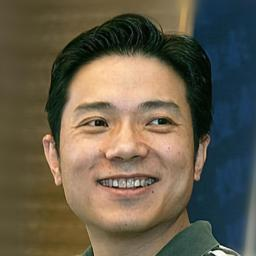

In [15]:
show_image('/content/test/00000.jpg',width=300, height=300)


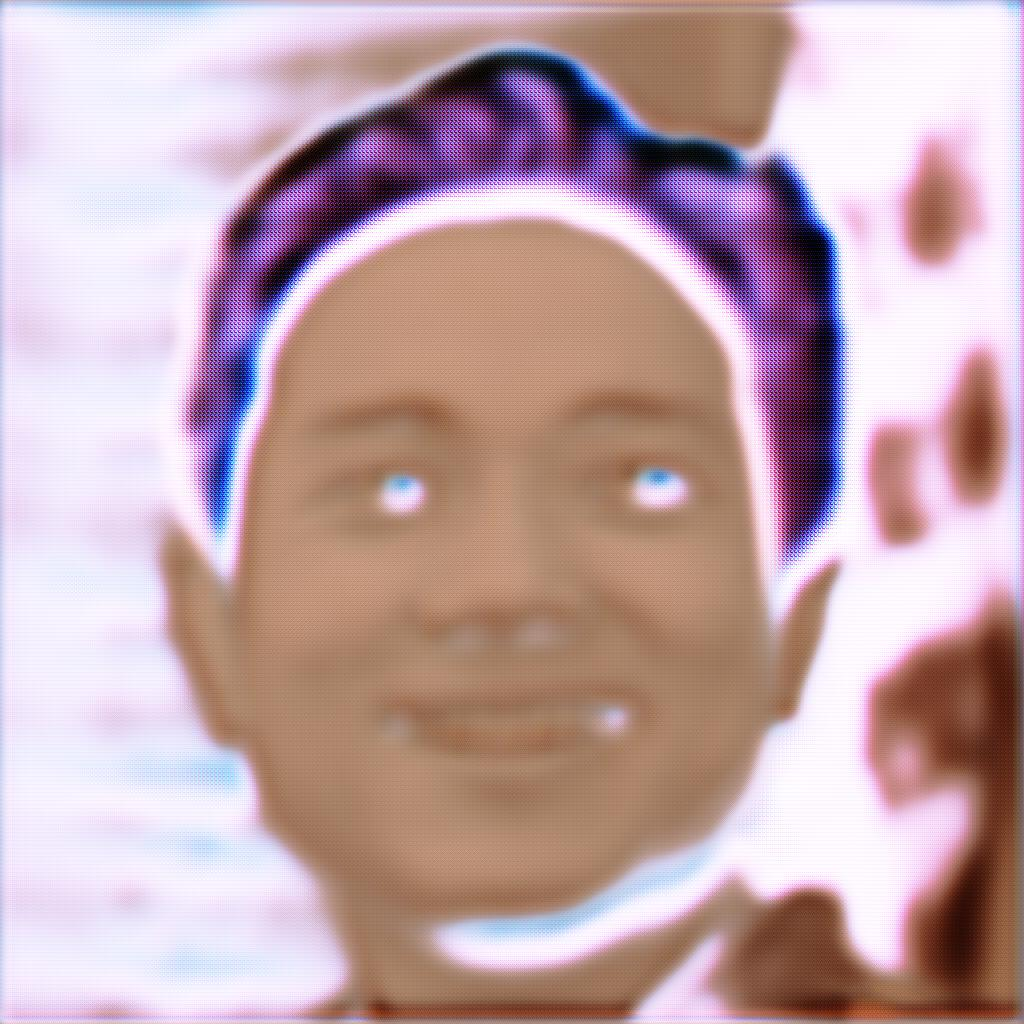

In [17]:
show_image('/content/saved/00000.jpg',width=300, height=300)